In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def D_1(series, dt, bins=250, tau=1, transform=None):
    ''' Retrieving n-dimensional Drift-Coefficient
    
    Parameters:
        - (array) series: array of n arrays which represent time series. n-dimensinal.
        - (float) dt: (time) difference between the values of series.
        - (int) bins: Number of bins. Defines the accuracy.
        - (int) tau: Number of timesteps to derivate further.
        - (lambda) transform: transform function to project series value to mesh.
            default: transform = lambda x, d, b: int((x + (d/2)) * np.floor(b / d)) - 1
        
    Returns:
        (array) Array of n-dim arrays, where the arrays represent the mean change of the i-th variable.
    '''
    dimension = len(series)
    
    # checking if all series have same size
    for i in range(dimension):
        if len(series[i]) != len(series[0]):
            raise Exception('Not all series have the same length')
    
    d = [np.max(el) - np.min(el) for el in series] # offsets
    l = [np.zeros(bins) for _ in range(dimension)] # n-dimension array

    a_grid = np.meshgrid(*l) # mesh to store changes
    b_grid = np.meshgrid(*l) # mesh to count occurences
    
    if transform is None:
        transform = lambda x, d, b: int((x + (d/2)) * np.floor(b / d)) - 1
    
    for i in range(len(series[0][:-tau])):
        # 1. transform series value to index value of grids
        c = [transform(series[j][i], d[j], bins) for j in range(dimension)]
        c = tuple(c)
        # 2. summate changes of the series and write to mesh
        for j in range(dimension):
            a_grid[j][c] += series[j][i + tau] - series[j][i]
        # 3. increment number of visits
        for j in range(dimension):
            b_grid[j][c] += 1
            
    # now calculate mean changes
    def calculate_mean_change_recursive(s, s_, argument=1):
        if type(s) == np.ndarray:
            for i in range(len(s)):
                s[i] = calculate_mean_change_recursive(s[i], s_[i], argument=argument)
        else:
            result = 0 if s_ == 0 else s / s_
            return argument * result
        return s
    for j in range(dimension):
        a_grid[j] = calculate_mean_change_recursive(a_grid[j], b_grid[j], argument=(1 / (tau * dt)))
        
    return a_grid

In [4]:
def D_2(series, dt, bins=250, tau=1, transform=None):
    '''Retrieving n-dimensional Diffusion-Coefficient
    
    Parameters:
            - (array) series: array of n arrays which represent time series. n-dimensinal.
            - (float) dt: (time) difference between the values of series.
            - (int) bins: Number of bins. Defines the accuracy.
            - (int) tau: Number of timesteps to derivate further.
            - (lambda) transform: transform function to project series value to mesh.
                default: transform = lambda x, d, b: int((x + (d/2)) * np.floor(b / d)) - 1

        Returns:
            (array) Array of n-dim arrays, where the arrays represent the mean change of the i-th variable.
    '''
    dimension = len(series)
    
    # checking if all series have same size
    for i in range(dimension):
        if len(series[i]) != len(series[0]):
            raise Exception('Not all series have the same length')
    
    d = [np.max(el) - np.min(el) for el in series] # offsets
    l = [np.zeros(bins) for _ in range(dimension)] # n-dimension array

    a_grid = np.meshgrid(*l) # mesh to store changes
    b_grid = np.meshgrid(*l) # mesh to count occurences
    
    a_grid = [a_grid[0] for _ in range(dimension * dimension)]
    
    if transform is None:
        transform = lambda x, d, b: int((x + (d/2)) * np.floor(b / d)) - 1
    
    for i in range(len(series[0][:-tau])):
        # 1. transform series value to index value of grids
        c = [transform(series[j][i], d[j], bins) for j in range(dimension)]
        c = tuple(c)
        # 2. summate and multiply changes of the series and write to mesh
        for k in range(dimension):
            for j in range(dimension):
                d_c = k * dimension + j
                a_grid[d_c][c] += (series[j][i + tau] - series[j][i]) * (series[k][i + tau] - series[k][i])
        # 3. increment number of visits
        for j in range(dimension):
            b_grid[j][c] += 1
            
    # now calculate mean changes
    def calculate_mean_change_recursive(s, s_, argument=1):
        if type(s) == np.ndarray:
            for i in range(len(s)):
                s[i] = calculate_mean_change_recursive(s[i], s_[i], argument=argument)
        else:
            result = 0 if s_ == 0 else s / s_
            return argument * result
        return s
    for j in range(dimension):
        a_grid[j] = calculate_mean_change_recursive(a_grid[j], b_grid[j], argument=(1 / (tau * dt)))
        
    return a_grid

## read the data from text files

In [5]:
# import simulated data
data_simulated = pd.read_csv('./ECG_data/SimulatedECG.txt', sep=" ", header=1)
data_simulated.columns = ['time', 'E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']

In [6]:
# import measured data
data_measured = pd.read_csv('./ECG_data/MeasuredECG.txt', sep=" ", header=1)
data_measured.columns = ['time', 'E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']

<IPython.core.display.Javascript object>


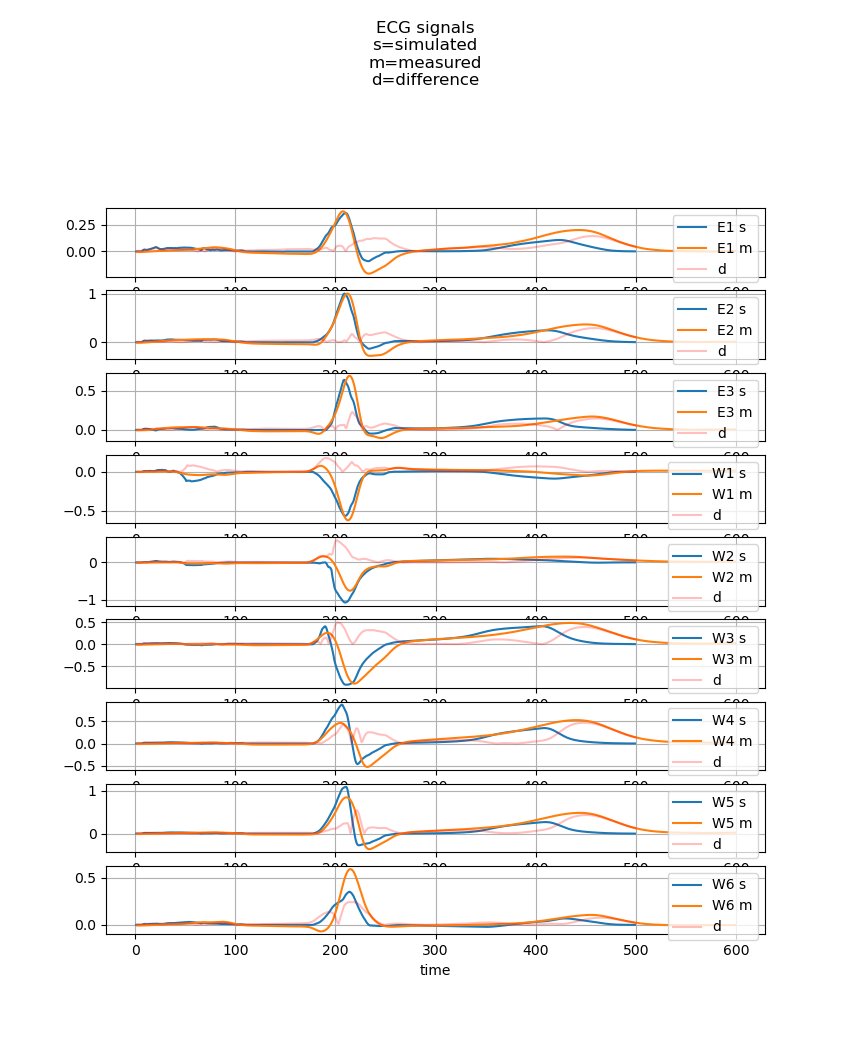

In [11]:
%matplotlib notebook
fig = plt.figure(figsize=(8.5, 10.5))
fig.suptitle('ECG signals\ns=simulated\nm=measured\nd=difference')

header = ['time', 'E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']
l = len(header)
for i in range(l):
    if header[i] == 'time': continue

    fig.add_subplot(l, 1, i + 1)
    plt.plot(data_simulated['time'], data_simulated[header[i]], label=header[i] + ' s')
    plt.plot(data_measured['time'], data_measured[header[i]], label=header[i] + ' m')
    plt.plot(data_measured['time'], abs(data_simulated[header[i]] - data_measured[header[i]]), c='r', alpha=.25, label='d')
    plt.grid()
    plt.legend(loc='upper right')

plt.xlabel('time')
plt.show()

## 1D analysis of ECG timeseries
```From simulated data!```

In [12]:
data_simulated['time'][2] - data_simulated['time'][1] 

1

In [148]:
#header = ['time', 'E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']

selector = 'E1'

time_series = [data_simulated[selector]]
dt = 1
bins = 100
tau = 1

minimal_value_offset = abs(min(time_series[0]))

transform = lambda x, d, b: int((x + minimal_value_offset) * np.floor(b / d)) - 1 # no offset d

sa_ds_d1 = D_1(time_series, dt, bins, tau, transform=transform)

<IPython.core.display.Javascript object>


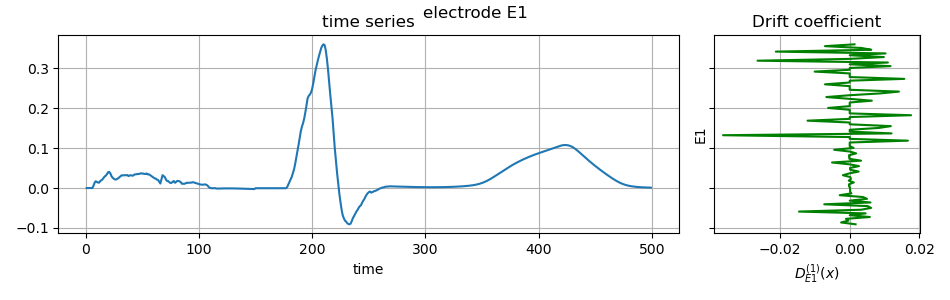

In [149]:
%matplotlib notebook
fig, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[3, 1]}, sharey=True, figsize=(9.5, 3))

a0.plot(data_simulated['time'], data_simulated[selector], label=selector)
a0.set_title('time series')
a0.set_xlabel('time')
a0.grid()

a1.plot(sa_ds_d1[0], np.linspace(min(time_series[0]), max(time_series[0]), bins), c='g')
a1.set_title('Drift coefficient')
a1.set_ylabel(selector)
a1.set_xlabel('$D_{%s}^{(1)}(x)$' % (selector))
a1.grid()

fig.suptitle('electrode %s' % (selector))
fig.tight_layout()
fig.show()

### Now the same but for all channels

<ipython-input-155-b64a3357ecf3>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-155-b64a3357ecf3>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-155-b64a3357ecf3>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-155-b64a3357ecf3>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-155-b64a3357ecf3>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-155-b64a3357ecf3>:33: UserWarning: Matpl

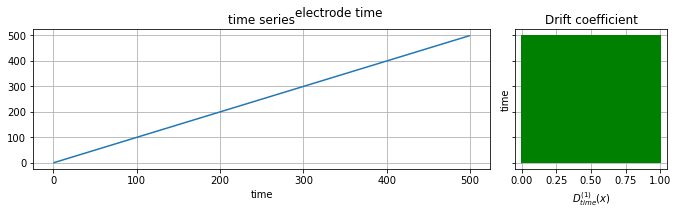

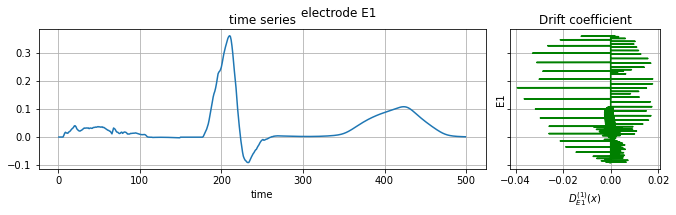

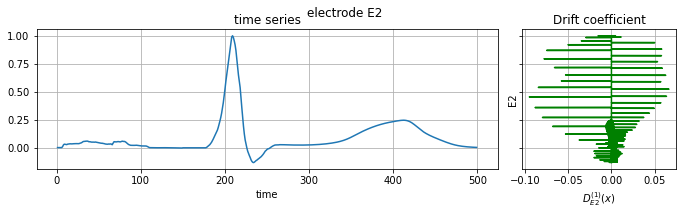

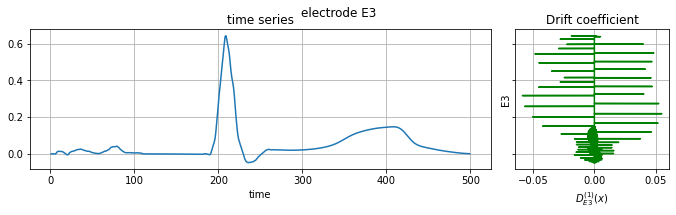

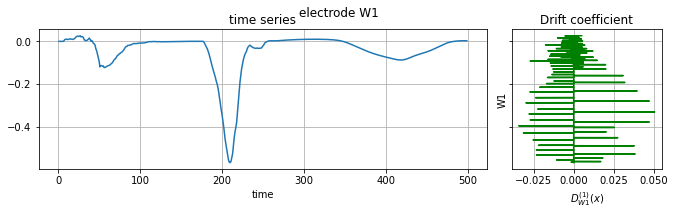

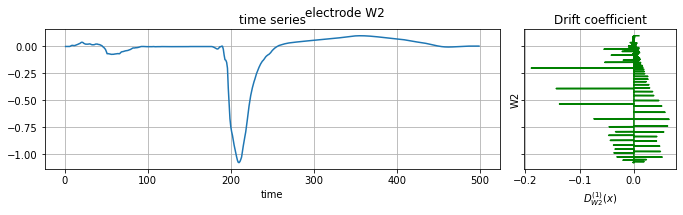

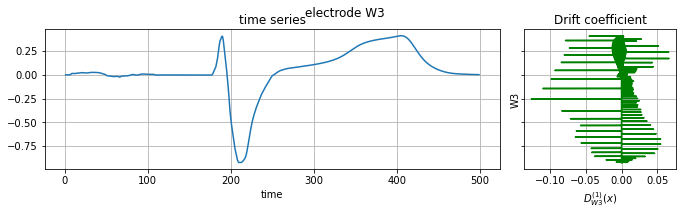

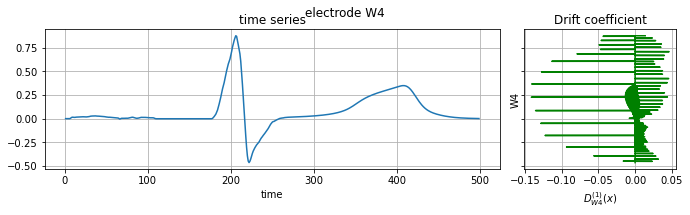

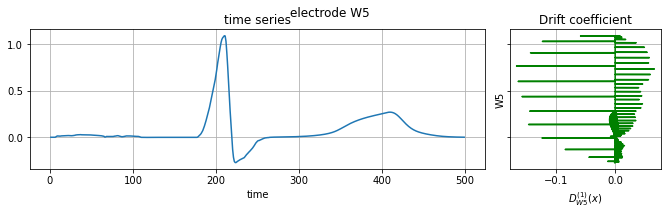

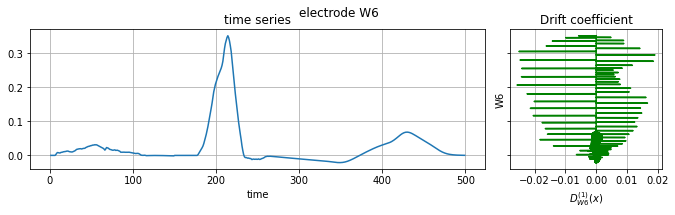

In [155]:
%matplotlib inline
headers = ['time', 'E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']

for selector in headers:
    time_series = [data_simulated[selector]]
    dt = 1
    bins = 10000
    tau = 1

    minimal_value_offset = abs(min(time_series[0]))

    transform = lambda x, d, b: int((x + minimal_value_offset) * np.floor(b / d)) - 1 # no offset d

    sa_ds_d1 = D_1(time_series, dt, bins, tau, transform=transform)

    # plot
    #%matplotlib notebook
    fig, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[3, 1]}, sharey=True, figsize=(9.5, 3))

    a0.plot(data_simulated['time'], data_simulated[selector], label=selector)
    a0.set_title('time series')
    a0.set_xlabel('time')
    a0.grid()

    a1.plot(sa_ds_d1[0], np.linspace(min(time_series[0]), max(time_series[0]), bins), c='g')
    a1.set_title('Drift coefficient')
    a1.set_ylabel(selector)
    a1.set_xlabel('$D_{%s}^{(1)}(x)$' % (selector))
    a1.grid()

    fig.suptitle('electrode %s' % (selector))
    fig.tight_layout()
    fig.show()

Generally the figures above are not very descriptively. At the times where the coefficient are "filled" with green, there is a clearly drift in one direction. But the other times, where the coefficients are zero, the rise and falls of the time series nearly compensate each other. We need here a moredimensional analysis.

## 3D Drift coefficient
```From simulated data!```

E1 = LA – RA

E2 = LL – RA

E3 = LL – LA

W1  = V1 – (LA + RA + LL)/3

W2  = V2 – (LA + RA + LL)/3

W3  = V3 – (LA + RA + LL)/3

W4  = V4 – (LA + RA + LL)/3

W5  = V5 – (LA + RA + LL)/3

W6  = V6 – (LA + RA + LL)/3

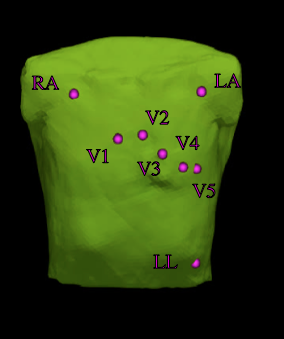

### First a 2D Drift coefficient of E1 and E2

In [198]:
#header = ['time', 'E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']

time_series = [data_simulated['E1'], data_simulated['E2']]
dt = 1
bins = 100
tau = 1

minimal_value_offset = abs(min(np.array(time_series).flatten()))

transform = lambda x, d, b: int((x + minimal_value_offset) *.91 * np.floor(b / d)) - 1

sa_ds_d1 = D_1(time_series, dt, bins, tau, transform=transform)

<IPython.core.display.Javascript object>


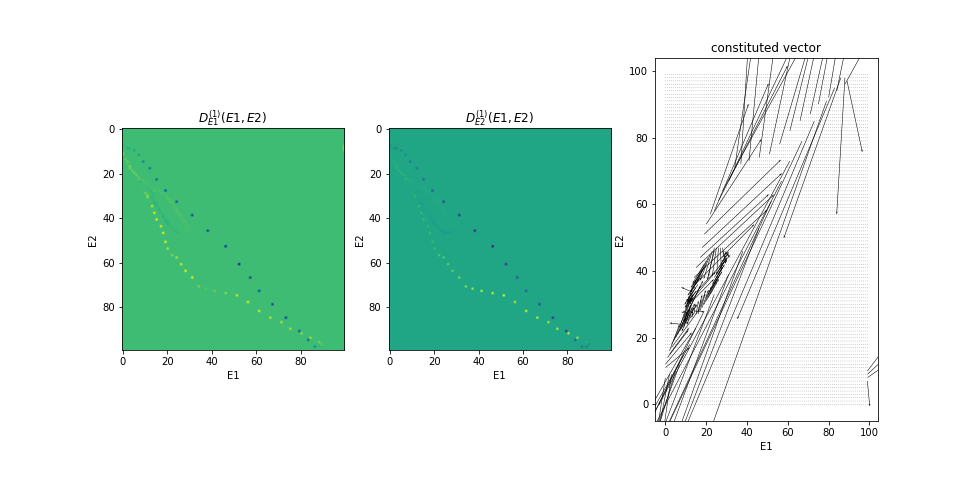

In [206]:
%matplotlib notebook
plt.subplot(131)
plt.title('$D_{E1}^{(1)}(E1, E2)$')
plt.xlabel('E1')
plt.ylabel('E2')
plt.imshow(sa_ds_d1[0])
plt.subplot(132)
plt.title('$D_{E2}^{(1)}(E1, E2)$')
plt.xlabel('E1')
plt.ylabel('E2')
plt.imshow(sa_ds_d1[1])
plt.subplot(133)
plt.title('constituted vector')
plt.xlabel('E1')
plt.ylabel('E2')
plt.quiver(sa_ds_d1[0], sa_ds_d1[1])
plt.show()

This stuff looks wild. But there is also some kind of cycle visible. This is good! To improve this, we should use a more noised and longer dataset.

### One truly 3D analysis of E1, E2, and E3

In [210]:
normaxis = lambda bins, dimension: np.meshgrid(*[np.arange(0, bins) for _ in range(dimension)])

In [208]:
#header = ['time', 'E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']

time_series = [data_simulated['E1'], data_simulated['E2'], data_simulated['E3']]
dt = 1
bins = 100
tau = 1

minimal_value_offset = abs(min(np.array(time_series).flatten()))

transform = lambda x, d, b: int((x + minimal_value_offset) *.9 * np.floor(b / d)) - 1

sa_ds_d1 = D_1(time_series, dt, bins, tau, transform=transform)

In [233]:
np.shape(d1)

(100, 100, 100)

In [247]:
d1 = sa_ds_d1[0]
d1[d1 == 0] = np.nan

d2 = sa_ds_d1[1]
d2[d2 == 0] = np.nan

d3 = sa_ds_d1[2]
d3[d3 == 0] = np.nan

<IPython.core.display.Javascript object>


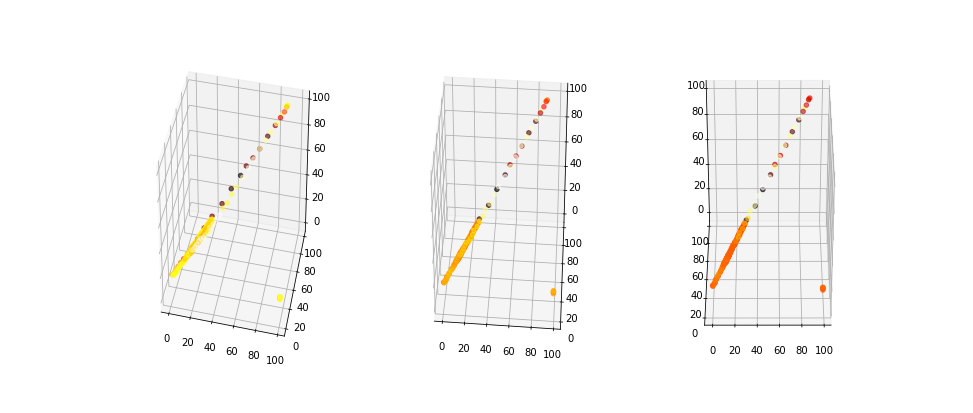

In [241]:
%matplotlib notebook
fig = plt.figure()

x_1, x_2, x_3 = normaxis(bins, len(time_series))

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.scatter(x_1, x_2, x_3, c=d1, cmap=plt.hot())

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.scatter(x_1, x_2, x_3, c=d2, cmap=plt.hot())

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.scatter(x_1, x_2, x_3, c=d3, cmap=plt.hot())

plt.show()

<IPython.core.display.Javascript object>


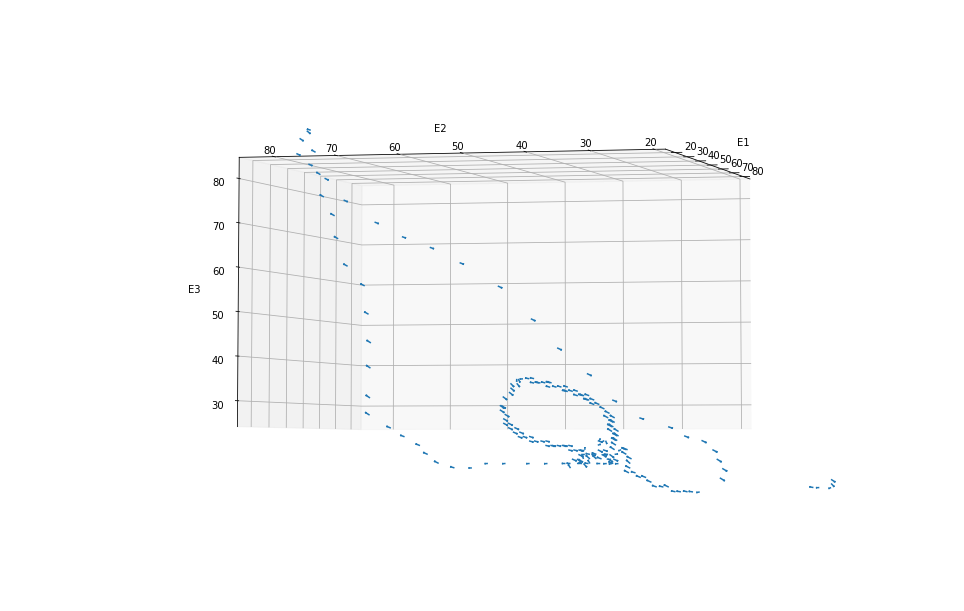

In [255]:
%matplotlib notebook
fig = plt.figure()

ax = fig.gca(projection='3d')

ax.quiver(x_1, x_2, x_3, d1, d2, d3, normalize=True)

ax.set_xlabel('E1')
ax.set_ylabel('E2')
ax.set_zlabel('E3')

plt.show()